In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

In [5]:
import pandas as pd

In [86]:
import kagglehub
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /Users/sowrabhnaik/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [87]:
import shutil
import os

# Source folder (KaggleHub cache)
src_folder = "/Users/sowrabhnaik/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2"

# Destination folder (your project folder)
dst_folder = os.path.join(os.getcwd(), "skin_cancer_dataset")

# Copy the entire folder
shutil.copytree(src_folder, dst_folder, dirs_exist_ok=True)

print(f"Dataset moved to: {dst_folder}")


Dataset moved to: /Users/sowrabhnaik/projects/Skinlesion/skin_cancer_dataset


In [88]:
metadata_path = os.path.join(path, "HAM10000_metadata.csv")
metadata = pd.read_csv(metadata_path)

In [89]:
print("Classes and counts:")
print(metadata['dx'].value_counts())

Classes and counts:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


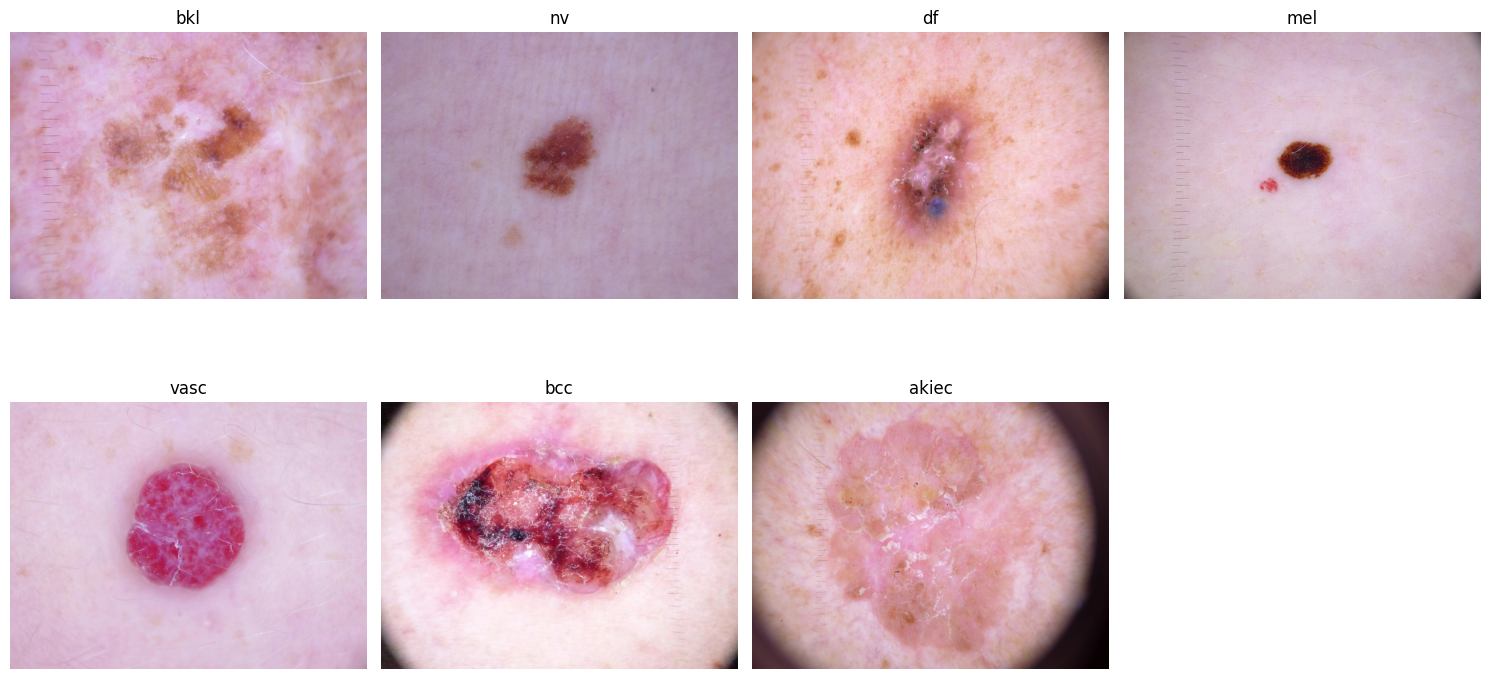

In [90]:
import matplotlib.image as mpimg
path = "/Users/sowrabhnaik/projects/Skinlesion/skin_cancer_dataset"

metadata = pd.read_csv(os.path.join(path, "HAM10000_metadata.csv"))

folders = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
image_files = []

for f in folders:
    folder_path = os.path.join(path, f)
    image_files += [os.path.join(folder_path, img) for img in os.listdir(folder_path)]

# Create dictionary mapping image_id -> full filepath
image_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in image_files}

# Plot one example per class
classes = metadata['dx'].unique()
plt.figure(figsize=(15, 8))

for i, cls in enumerate(classes):
    img_id = metadata[metadata['dx'] == cls]['image_id'].iloc[0]
    img_path = image_dict.get(img_id)
    
    if img_path: 
        img = mpimg.imread(img_path)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [91]:
path = "/Users/sowrabhnaik/projects/Skinlesion/skin_cancer_dataset"

# Load metadata
metadata = pd.read_csv(os.path.join(path, "HAM10000_metadata.csv"))

# Create dictionary mapping image_id -> full filepath
folders = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
image_files = []
for f in folders:
    folder_path = os.path.join(path, f)
    image_files += [os.path.join(folder_path, img) for img in os.listdir(folder_path)]

image_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in image_files}

# Add full image path to metadata
metadata['image_path'] = metadata['image_id'].map(image_dict)

# Split 60-20-20 (train-val-test) stratified by class
trainval_df, test_df = train_test_split(
    metadata, test_size=0.15, stratify=metadata['dx'], random_state=42
)
train_df, val_df = train_test_split(
    trainval_df, test_size=0.15, stratify=trainval_df['dx'], random_state=42
)

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)


Train: (7235, 8)
Validation: (1277, 8)
Test: (1503, 8)


In [92]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7235 validated image filenames belonging to 7 classes.
Found 1277 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


In [93]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(train_df['dx'])
class_weights = compute_class_weight(
    'balanced',
    classes=classes,
    y=train_df['dx']
)
class_weight_dict = dict(zip(range(len(classes)), class_weights))
print(class_weight_dict)


{0: np.float64(4.37953995157385), 1: np.float64(2.778417818740399), 2: np.float64(1.3017272400143938), 3: np.float64(12.452667814113598), 4: np.float64(1.2855366027007817), 5: np.float64(0.21337147575793322), 6: np.float64(10.133053221288515)}


In [94]:
num_classes = len(train_generator.class_indices)
print(num_classes)

7


In [95]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu',kernel_initializer='he_normal'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,247 (92.02 MB)

 Trainable params: 530,439 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [98]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



In [99]:
stage1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]   
)

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.4746 - loss: 2.1460 - val_accuracy: 0.6413 - val_loss: 1.1753 - learning_rate: 0.0010
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.5303 - loss: 1.5499 - val_accuracy: 0.6312 - val_loss: 1.1722 - learning_rate: 0.0010
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.5686 - loss: 1.2745 - val_accuracy: 0.6006 - val_loss: 1.3960 - learning_rate: 0.0010
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.5869 - loss: 1.1885 - val_accuracy: 0.6570 - val_loss: 1.1948 - learning_rate: 0.0010
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6200 - loss: 1.0531
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
227/227 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.6050 - loss: 1.0583 - val_accuracy: 0.4965 - val_loss: 1.9997 - learning_rate: 0.0010
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 478s 2s/step - accuracy: 0.5972 - loss: 0.97

In [100]:
base_model.trainable = True
# Freeze first 100 layers, fine-tune remaining
for layer in base_model.layers[:100]:
    layer.trainable = False

In [101]:
model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [102]:
stage2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)


Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 891s 4s/step - accuracy: 0.5811 - loss: 1.0722 - val_accuracy: 0.6609 - val_loss: 0.9054 - learning_rate: 1.0000e-05
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 937s 4s/step - accuracy: 0.6025 - loss: 0.8991 - val_accuracy: 0.6476 - val_loss: 0.9372 - learning_rate: 1.0000e-05
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6150 - loss: 0.7926
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
227/227 ━━━━━━━━━━━━━━━━━━━━ 915s 4s/step - accuracy: 0.6174 - loss: 0.8113 - val_accuracy: 0.6319 - val_loss: 0.9436 - learning_rate: 1.0000e-05
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 844s 4s/step - accuracy: 0.6381 - loss: 0.7498 - val_accuracy: 0.6500 - val_loss: 0.9150 - learning_rate: 5.0000e-06
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6498 - loss: 0.7646
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
227/227 ━━━━━━━━━━━━━━━━━━━━ 854s 4s/step - accuracy: 0.6451 

In [103]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 974ms/step - accuracy: 0.6820 - loss: 0.8854
Test Accuracy: 0.6820


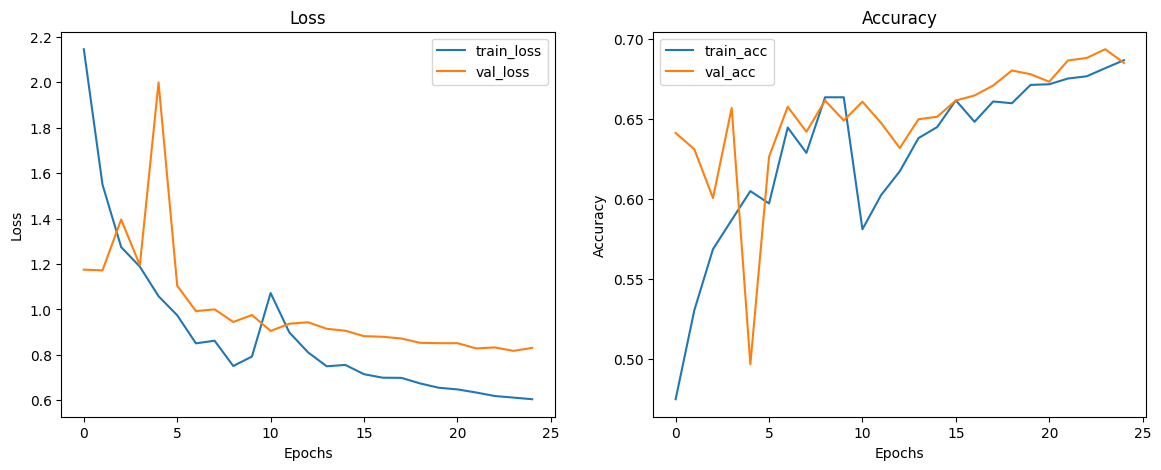

40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 969ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 942ms/step
Validation AUC: 0.9435
Test AUC: 0.9393


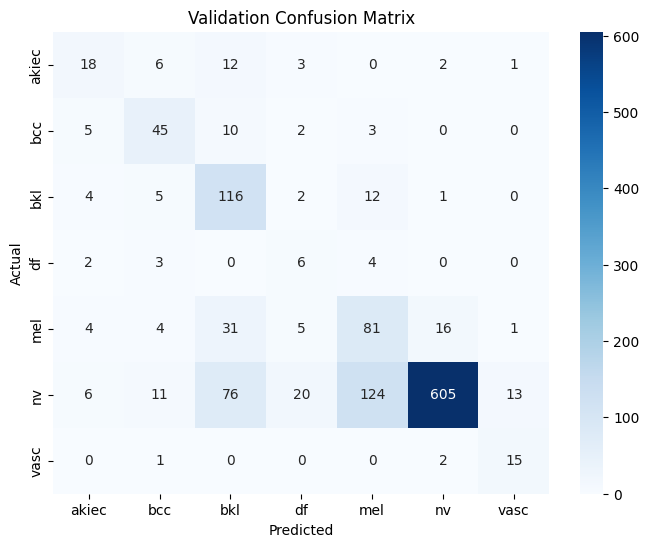

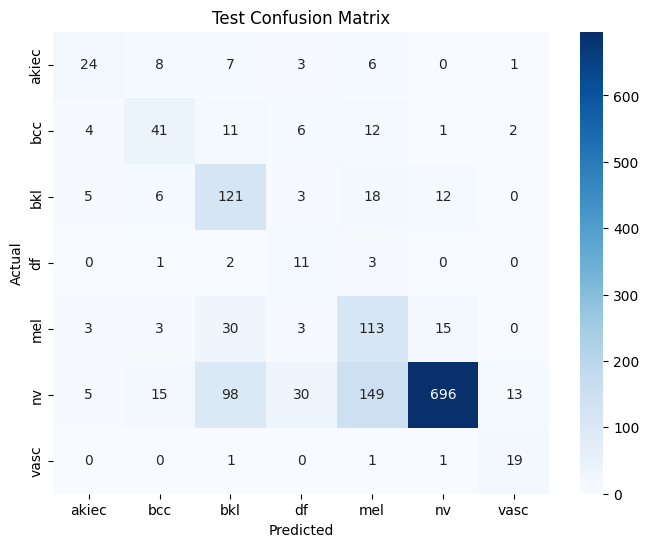

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np

# Combine histories
def combine_histories(histories):
    combined = {}
    for key in histories[0].history.keys():
        combined[key] = np.concatenate([h.history[key] for h in histories])
    return combined

combined_history = combine_histories([stage1, stage2])

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(combined_history['loss'], label='train_loss')
plt.plot(combined_history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(combined_history['accuracy'], label='train_acc')
plt.plot(combined_history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- AUC for train and validation ---

y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator, verbose=1)
y_test_true = test_generator.classes
y_test_pred = model.predict(test_generator, verbose=1)

# Compute AUC
val_auc = roc_auc_score(tf.keras.utils.to_categorical(y_val_true), y_val_pred, multi_class='ovr')
test_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test_true), y_test_pred, multi_class='ovr')
print(f"Validation AUC: {val_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# --- Confusion Matrices ---
def plot_confusion_matrix(y_true, y_pred_probs, classes, title='Confusion Matrix'):
    y_pred = np.argmax(y_pred_probs, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

class_names = list(train_generator.class_indices.keys())

plot_confusion_matrix(val_generator.classes, y_val_pred, class_names, title='Validation Confusion Matrix')
plot_confusion_matrix(test_generator.classes, y_test_pred, class_names, title='Test Confusion Matrix')
